In [613]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy import signal

In [719]:
def smooth_timeseries(t, size=5, axis=0):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=axis, arr=t)

In [720]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_raw']
deaths = datadict['deaths_raw']

In [721]:
demographics = u.load_demographics_data()
pop = demographics['total_pop']

In [722]:
county = 1868
d = deaths[county] 
d1 = np.diff(d)

c = cases[county]
c1 = np.diff(c)

In [725]:
s = 7
d_smooth = smooth_timeseries(d1,s)
c_smooth = smooth_timeseries(c1,s)

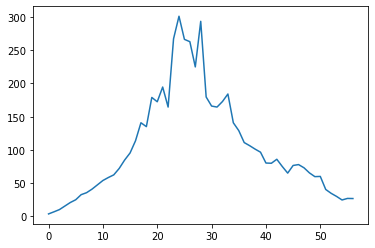

In [726]:
y = d_smooth
y = y[y > 0]
x = np.arange(0, y.shape[0])
plt.plot(x, y)

In [584]:
scale = c_smooth.max() / d_smooth.max()

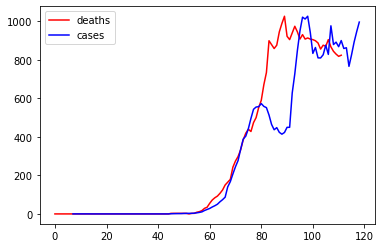

In [585]:
y = d_smooth * scale
x = np.arange(0, y.shape[0])
plt.plot(x, y, color='red', label='deaths')

y = c_smooth
x = np.arange(0, y.shape[0])
x += 7
plt.plot(x, y, color='blue', label='cases')

# plt.xlim(left=50)
plt.legend()

In [586]:
delays = np.arange(1, 15)
corr = []
for delay in delays:
    cases_past = []
    deaths_curr = []
    for i in range(delay, c_smooth.shape[0]):
        cases_past.append(c_smooth[i - delay])
        deaths_curr.append(d_smooth[i])
    co = np.corrcoef(cases_past, deaths_curr)[0, 1]
    corr.append(co)

In [595]:
delay = 7
colors = []
cases_past = []
deaths_curr = []
for i in range(delay + 1, c_smooth.shape[0]):
    cases_past.append(c_smooth[i - delay])
    deaths_curr.append(d_smooth[i])
    colors.append(i)

In [596]:
np.corrcoef(cases_past, deaths_curr)[0, 1]

0.02569385442161944

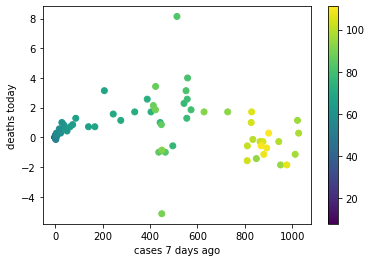

In [597]:
plt.scatter(cases_past, deaths_curr, c=colors)
plt.xlabel(f'cases {delay} days ago')
plt.ylabel('deaths today')
plt.colorbar()

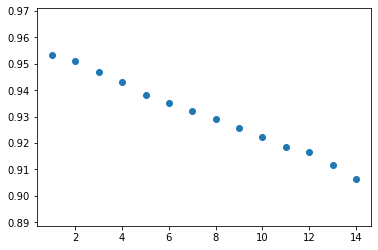

In [590]:
plt.scatter(delays, corr)

In [718]:
(5 % 2)

1

In [727]:
def smooth_timeseries2(t, size=5):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(0, 0), (size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'),
        axis=1, arr=t)

In [445]:
cases_change = np.diff(cases)
deaths_change = np.diff(deaths)
s = 7
cases_change_s = smooth_timeseries2(cases_change, s)
deaths_change_s = smooth_timeseries2(deaths_change, s)

In [446]:
print(deaths_change_s.shape, cases_change_s.shape)

(3143, 113) (3143, 113)


In [591]:
delay = 14
cases_past = []
deaths_curr = []
colors = []
skip = 3
for county in range(cases_change_s.shape[0]):
    if deaths[county].max() < 50:
        continue
#     if 1850 < county < 1890:
#         continue
    for t in range(delay, cases_change_s.shape[1], skip):
        if t < 40:
            continue
        if deaths_change_s[county, t] == 0:
            continue
        cases_past.append(cases_change_s[county, t - delay])
        deaths_curr.append(deaths_change_s[county, t])
        colors.append(county)

In [592]:
print(len(deaths_curr))

3316


In [593]:
np.corrcoef(cases_past, deaths_curr)[0, 1]

0.8341963849508441

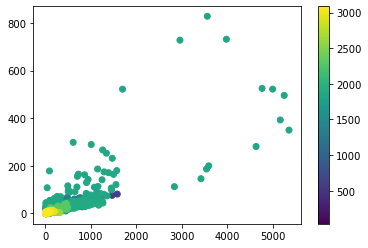

In [594]:
plt.scatter(cases_past, deaths_curr, c=colors)
plt.colorbar()
#plt.xlim(right=2000)
#plt.ylim(0, 350)